<h3 style="text-align:center">Image and text classification using CNN</h3>

Image classification

In [1]:
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Inferencing

In [3]:
with open("imagenet1000_clsidx_to_labels.txt") as f:
    labels = eval(f.read())

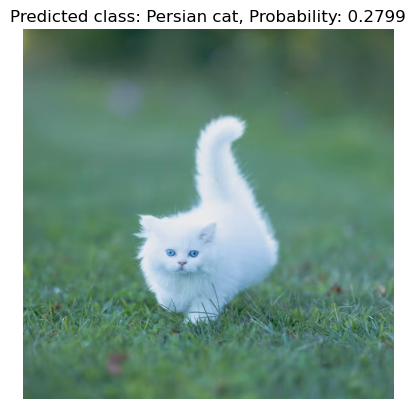

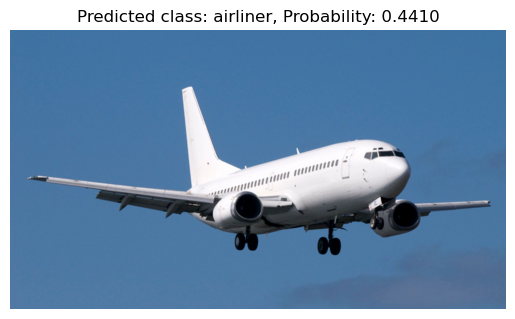

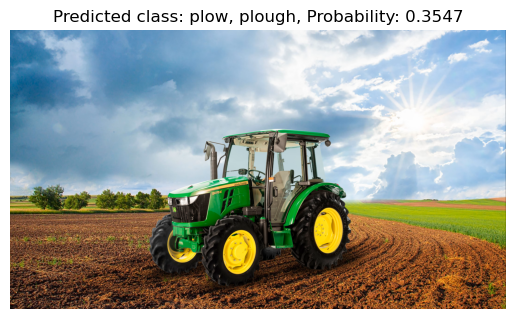

In [4]:
preprocessor = ResNet50_Weights.IMAGENET1K_V2.transforms()
test_images = ["cat.png", "plane.png", "tractor.png"]

transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


for img_path in test_images:
    test_image = Image.open(img_path).convert("RGB")
    # test_image = T.ToTensor()(test_image)
    input_image = transforms(test_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_image)

    predicted_probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_probabilities, predicted_classes = torch.topk(predicted_probabilities, 5)

    label = labels[predicted_classes[0].item()]
    probability = predicted_probabilities[0].item()

    plt.imshow(test_image)
    plt.axis('off')
    plt.title(f"Predicted class: {label}, Probability: {probability:.4f}")
    plt.show()

Text classification

In [5]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

In [6]:
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hr15h1k35h/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/hr15h1k35h/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Creating a CNN for text classification

In [8]:
# class TextClassifier(nn.Module):
#     def __init__(self, vocab_size, embed_dim, num_classes):
#         super(TextClassifier, self).__init__()
        
#         self.embedding = nn.Embedding(vocab_size, embed_dim)

#         self.conv1 = nn.Conv1d(embed_dim, 128, 3)
#         self.conv2 = nn.Conv1d(128, 64, 3)
#         self.conv3 = nn.Conv1d(64, 32, 3)

#         self.pool = nn.MaxPool1d(2)
#         self.fc1 = nn.Linear(32 * 24, 128)
#         self.fc2 = nn.Linear(128, num_classes)
#         self.dropout = nn.Dropout(0.5)
#         self.dropout2 = nn.Dropout(0.3)
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.embedding(x)
#         x = x.permute(0, 2, 1)

#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.pool(x)

#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.pool(x)

#         x = self.conv3(x)
#         x = self.relu(x)
#         x = self.pool(x)

#         x = x.view(x.size(0), -1)
#         x = self.dropout(x)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.dropout2(x)

#         x = self.fc2(x)
#         x = self.sigmoid(x)

#         return x


In [9]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    text = nltk.word_tokenize(text)

    text = [word for word in text if len(word) > 2]

    text = ' '.join([word for word in text if word not in stop_words])
    return text

In [10]:
df["review"] = df["review"].apply(preprocess_text)
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})
df.head()

,review,sentiment
0,one reviewers mentioned watching episode youll...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1
